In [1]:
library(stringr)
library(RColorBrewer)
library(parallel)

In [2]:
setwd("/nfs/lab/projects/pbmc_snATAC/analysis_v2")

In [4]:
bcs = read.table('peaks/pbmc1-15_clusterLabels.txt', header=T, sep="\t")

In [7]:
tabsum = table(bcs$fine_populations, bcs$sample)

In [11]:
ids = c(2:5, 8:10,12:14) 

In [14]:
tabsum = tabsum[,paste0("pbmc", ids)]

In [15]:
tabsum

             
              pbmc2 pbmc3 pbmc4 pbmc5 pbmc8 pbmc9 pbmc10 pbmc12 pbmc13 pbmc14
  act_cd4_t     636   820  1177   929  1770  1346    920   1290   2140   1075
  adaptive_NK   146    72    42    26    71    25     48    147     75     80
  cDC            87    50    34    27   130    43     27     59    146    106
  cMono        2919  1633   960   917  2037  1522   2127   1377   1224   2789
  cyto_cd8_t    479   483   316   367   850   478    743   1165    713    345
  cyto_nk       761  1090   321   408   354   408    342    783    522   1349
  iMono         154   342    69    43    65    60     36     80   1041    231
  mem_b          71    73   162    49   194   177    152    140    296    166
  mem_cd8_t     149    98   193   135   584   151    137    409    201     52
  mkc           219    70    20     8    62    42     53     63    197    125
  naive_b       299   322   324    90   284   347    307    369    361    537
  naive_cd4_t   218   375   398   623  1084  1336 

In [82]:
sum(tabsum["cMono",])
mean(tabsum["cMono",])

[1] 17505

[1] 1750.5

In [83]:
sort(rowMeans(tabsum))

plasma         pDC         cDC adaptive_NK         mkc       mem_b 
       12.6        30.2        70.9        73.2        85.9       148.0 
       tReg   mem_cd8_t       iMono     naive_b      ncMono naive_cd8_t 
      164.7       210.9       212.1       324.0       373.2       454.3 
 cyto_cd8_t     cyto_nk naive_cd4_t   act_cd4_t       cMono 
      593.9       633.8       992.1      1210.3      1750.5

In [86]:
tabsum = table(bcs$broad_populations_2, bcs$sample)

In [88]:
sort(rowMeans(tabsum))

plasma        pDC        mkc          b         nk       mono          t 
  12.84615   29.23077   86.15385  563.38462  728.23077 2382.76923 3582.15385

In [17]:
thresh = c(10,25,50,100,250,500,1000,2000)

In [42]:
make_cluster_bam = function(s, thresholds, sampdir, outdir) {
    
     sample_id      = paste0("pbmc",s)
     samp_outdir    = paste0( outdir,  '/PBMC', s, '/subsample_test')
     system(paste('mkdir -p', samp_outdir))
     setwd(samp_outdir)
     bam            = paste0(sampdir, "/PBMC", s, '/final/PBMC', s, '.merged.rmdup.final.bam' )
     system(paste("samtools view -H", bam ,"> SAM_header"))
     barcodes       = bcs$barcode[bcs$sample==sample_id & bcs$fine_populations=='cMono']
    
    for (celln in thresholds) {
        
       if (celln > length(barcodes)){
        barcodes_subset = sample(barcodes, celln, replace=T)
            } else {
        barcodes_subset = sample(barcodes, celln, replace=F)    
        }
        filename = paste0("sub", celln)
        writeLines(barcodes_subset, filename)
        system(paste('samtools view', bam , '| LC_ALL=C grep -F -f', filename , '> filtered_SAM_body'))
        system("cat SAM_header filtered_SAM_body > filtered.sam")
        system(paste0("samtools view -b filtered.sam > ", sample_id, "_",filename, ".bam"))
        system('rm filtered.sam filtered_SAM_body')
        system(paste0("samtools index ", sample_id, "_",filename, ".bam"))
}

     
}

In [43]:
sampdir = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp_peaks/singlecell/"
outdir  = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cell_type_bam/"
mclapply(ids, function(x) make_cluster_bam(s=x, thresholds=thresh[2:8], sampdir=sampdir ,outdir=outdir) , mc.cores = 24)  

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

## Feature Counts matrices

In [44]:
sampdir  = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/cell_type_bam/'
outdir   = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual/'
bedir    = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/peaks/'

In [45]:
saf = paste0(bedir, 'pbmc.sorted.merged.saf')

In [46]:
featurecounts = function(c, res = "subsample_test"){
outfolder     = paste(outdir, res, c, sep="/")
system(paste('mkdir -p' , outfolder))
count_matrix  = paste0(outfolder,"/" ,c, '.count_matrix')    
bam           = paste0(sampdir, "PBMC", ids,"/" ,res, '/pbmc', ids, "_", c, ".bam")
gi  <-  paste("featureCounts -p -T 10 -F SAF --donotsort -a" , saf, "-o",  count_matrix , 
                paste(bam,collapse=" "))
system(gi)
}


In [48]:
subsets =paste0("sub", thresh)

In [49]:
mclapply(subsets,featurecounts, mc.cores = 32 )

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

In [50]:
library("rasqualTools")
source("/nfs/lab/projects/pbmc_snATAC/scripts/rasqual_tools_functions.R")

In [55]:
res = "subsample_test"
celltypes   =  paste0("sub", thresh)


In [60]:
for (c in celltypes){
outfolder     = paste(outdir, res, c, sep="/")
cm = read.table(paste0(outfolder, "/" ,c, '.count_matrix') , header=T)
colnames(cm)[7:ncol(cm)] = paste0("PBMC", ids)

### filter for peaks having a minumum of 5 reads on avg per sample
cm = cm[rowMeans(cm[,7:ncol(cm)])>= 5, ]

fmat           = cm[,7:ncol(cm)]
rownames(fmat) = cm[,1]
filtbed        = paste0(outfolder, "/", c, ".filtered.bed")
write.table(fmat, paste0(outfolder, "/", c, ".filtered.count_matrix"), sep="\t", quote=F)
write.table(cm[,2:4],filtbed, sep="\t", quote=F, col.names=F, row.names=F)
cc     = cm[,2:4]
cc[,1] = substring(cc[,1],4)
write.table(cc, paste0(outfolder, "/", c, ".filtered.nochr.bed"), sep="\t", quote=F, col.names=F, row.names=F)

system(paste0("bedtools slop -i ",  filtbed,  " -b 10000 -g /nfs/lab/publicdata/human.hg19.genome.bedtools > ",
         filtbed, '.10kb'))

system(paste0("bedtools merge -i ", filtbed, '.10kb > ', filtbed, '.10kb.merged'))

fb     = read.table(paste0( filtbed, '.10kb.merged'))
fb[,1] = substring(fb[,1],4)
write.table(fb, paste0( filtbed, '.10kb.merged.nochr'), sep="\t", quote=F, col.names=F, row.names=F)

#### RAsqualTools

saveRasqualMatrices(list(counts = fmat), outfolder, file_suffix = c)

size_factors = rasqualCalculateSampleOffsets(fmat, gc_correct = FALSE)
saveRasqualMatrices(list(size_factors = size_factors),  outfolder, file_suffix = c)

y = paste0(outfolder, "/counts.",c, ".txt" )
k = paste0(outfolder, "/size_factors.",c, ".txt" )
x = paste0(outfolder, "/covariates.",c, ".txt" )

make_covariates (ytxt=y, ktxt=k, outfile=x)

txt2bin  (ytxt=y, ktxt=k, xtxt=x)
}

[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual//subsample_test/sub10/counts.sub10.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual//subsample_test/sub10/size_factors.sub10.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual//subsample_test/sub25/counts.sub25.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual//subsample_test/sub25/size_factors.sub25.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual//subsample_test/sub50/counts.sub50.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual//subsample_test/sub50/size_factors.sub50.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual//subsample_test/sub100/counts.sub100.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual//subsample_test/sub100/size_factors.sub100.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual//subsample_test/sub250/counts.sub250.txt"
[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual//subsample_test/sub250/size_factors.sub250.txt"
[1] "/nfs/la

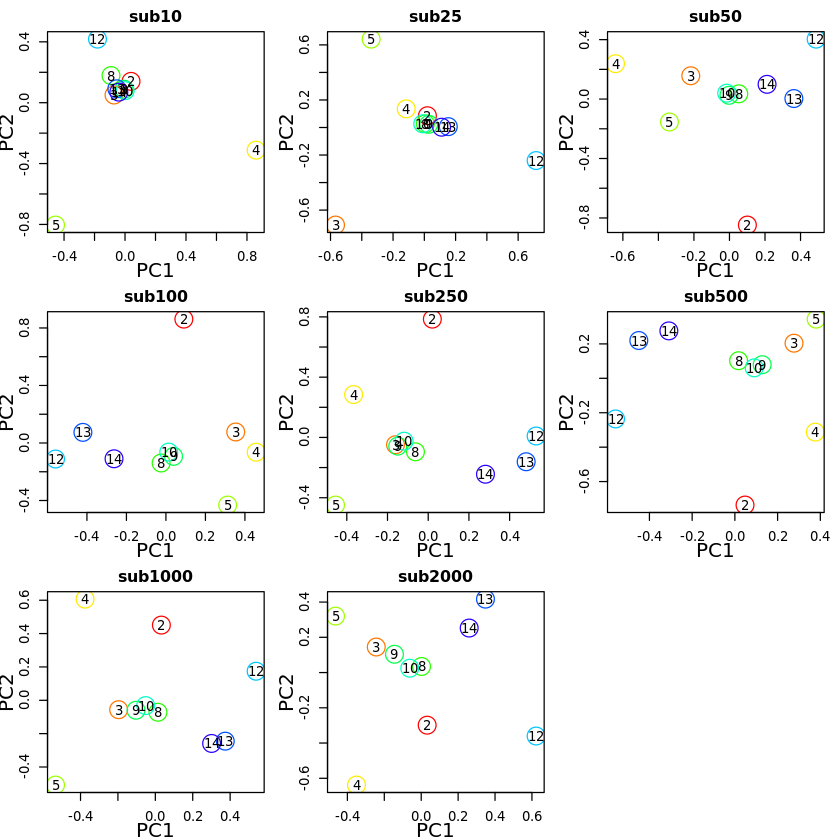

In [61]:
par(mfrow=c(3,3), mar =c(3,3,2,1))
for (c in celltypes){
outfolder     = paste(outdir, res, c, sep="/")
pca = read.table(paste0(outfolder, "/covariates.",c, ".txt" ))
   
plot(pca[,2:3], cex = 3, main = c, col = rainbow(13)) ## col1 is size factor
mtext(side = 1:2, text=c("PC1","PC2"), line=2)
text(pca[,2:3], labels = ids)
#plot(pca[,3:4], cex = 3, main = c) ## col1 is size factor
#text(pca[,3:4], labels = ids)
#mtext(side = 1:2, text=c("PC2","PC3"), line=2)    
}

Add genotype PCs

In [63]:
codir = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual/covariates/'
for (c in celltypes){
outfolder     = paste(outdir, res, c, sep="/")
y = paste0(outfolder, "/counts.",c, ".txt" )
k = paste0(outfolder, "/size_factors.",c, ".txt" )
x = paste0(outfolder, "/covariates.",c, ".txt" )

    
make_covariates (ytxt=y, ktxt=k, outfile=x) ###recalculate original ones 
#newcov = cbind(read.table(x), read.table(paste0(codir, "4_gt_pcs")))
newcov = cbind(read.table(x),#read.table(paste0(codir, "age")),
               #read.table(paste0(codir, "sex"))*0.1, 
               read.table(paste0(codir, "4_gt_pcs"))[-c(1,6,13),])

write.table( newcov, x, col=F,row=F,sep="\t",quote=F)
txt2bin  (ytxt=y, ktxt=k, xtxt=x)
}

### Prepare VCF Files

1.FIlter original vcf files for just  snps in peaks, samples of interest, imputation quality, heterozygous genotype and removing indels

In [64]:
reso    = res
vcf_dir  = '/nfs/lab/projects/pbmc_snATAC/pipeline/snp_array/final_vcfs/'
homedir  = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual/'
sampdir  = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/cell_type_bam/'
samples  = paste0("PBMC", ids)

In [72]:
samples

[1] "PBMC2"  "PBMC3"  "PBMC4"  "PBMC5"  "PBMC8"  "PBMC9"  "PBMC10" "PBMC12"
 [9] "PBMC13" "PBMC14"

In [75]:
filter_vcf = function(cell) {
        
    for (n in 1:22) {

    vcf    = paste0(vcf_dir, "/chr",n ,'.PBMC.topmed.hg19.final.vcf.gz')
    outdir = paste(homedir, reso, cell, "vcfs_peaksonly", sep="/")    
    system(paste("mkdir -p ",outdir  ) )   
    outvcf = paste0(outdir, "/chr",n ,'.filt.vcf')
    bed    = paste0(homedir, reso, "/",cell, "/" , cell, '.filtered.bed')
        
    system(paste('bcftools view', vcf ,
    '-R' , bed, '-s', paste(samples, collapse=","),
    "-i \'INFO/R2[0]>0.7\' | bcftools view -g het --types snps -o" , outvcf))
}
    }

In [76]:
mclapply(celltypes, function(x) filter_vcf(x) , mc.cores = 34)

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

In [77]:
for (cell in celltypes) {
setwd(paste(homedir, reso, cell, "vcfs_peaksonly", sep="/"))
system("bcftools concat chr1.filt.vcf chr2.filt.vcf chr3.filt.vcf chr4.filt.vcf chr5.filt.vcf chr6.filt.vcf chr7.filt.vcf chr8.filt.vcf chr9.filt.vcf chr10.filt.vcf chr11.filt.vcf chr12.filt.vcf chr13.filt.vcf chr14.filt.vcf chr15.filt.vcf chr16.filt.vcf chr17.filt.vcf chr18.filt.vcf chr19.filt.vcf chr20.filt.vcf chr21.filt.vcf chr22.filt.vcf -Oz -o full.chr.vcf.gz")
#system("awk \'{if($0 !~ /^#/) print \"chr\"$0; else print $0}\' full.vcf > full.chr.vcf")
#system('bgzip full.chr.vcf -f')
system('tabix full.chr.vcf.gz -f')
    }

In [78]:
for (cell in celltypes){
new_vcf_dir = paste0(homedir, reso,"/" ,cell, "/vcfs_peaksonly" )    
bam = paste0(sampdir, "PBMC", ids,"/", reso, '/pbmc', ids, "_", cell, ".bam")
writeLines(bam, paste(new_vcf_dir, 'bam.list.txt', sep="/"))
    }

In [79]:
rasqual_ase = function (cell, reso){
setwd(paste0(homedir, reso,"/" ,cell, "/vcfs_peaksonly" )  )
system("rm full.ase*")   ## remove older files 
system('bash /nfs/lab/paola/rasqual/src/ASVCF/createASVCF.sh paired_end bam.list.txt full.chr.vcf.gz full.ase.vcf.gz atac')
system('bcftools view full.ase.vcf.gz -i \'COUNT(GT=\"het\")>1\' -Oz -o full.ase.filtered.vcf.gz')
system('tabix full.ase.filtered.vcf.gz -f')
    }

In [80]:
mclapply(celltypes, function (x) rasqual_ase(cell=x, reso=reso),mc.cores = 24)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0